In [1]:
from google.colab import userdata
token = userdata.get('hf_token')

In [30]:
# !pip install bitsandbytes accelerate

In [4]:
%%time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import re

# Load and preprocess data
data = pd.read_csv('/content/weatherHistory.csv')
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)
data = data.sort_values('Formatted Date')

# Aggregate to daily data
# daily_data = data.resample('1D', on='Formatted Date').mean().reset_index()
temperature_series = data['Temperature (C)'].values

# Prepare sliding window data (7-day window)
window_size = 7
X = []
y = []

for i in range(len(temperature_series) - window_size):
    X.append(temperature_series[i:i + window_size])
    y.append(temperature_series[i + window_size])

# 4-bit quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

# Load Mistral 7B model and tokenizer
model_name = "mistralai/Mistral-7B-Instruct-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=token)
model = AutoModelForCausalLM.from_pretrained(model_name, use_auth_token=token, quantization_config=quantization_config, device_map="auto")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:833: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [20]:
%%time

# extract the answer
def extract_first_number(text):
    matches = re.findall(r"[-+]?\d*\.\d+|\d+", text)
    if matches:
        return float(matches[-1])
    return None

# Query Mistral 7B locally
def query_mistral(input_series):
    prompt = f"Given the past 7 daily temperatures: {input_series.tolist()}, predict the next day's temperature. Reply with a number."

    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"\n Raw Mistral output: {response}")
    predicted_temp = extract_first_number(response)
    return predicted_temp if predicted_temp is not None else 0.0

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


## 10 days

⏳ Predicting for day 1/10

 Raw Mistral output: Given the past 7 daily temperatures: [0.5777777777777773, 1.161111111111113, 1.6666666666666667, 1.71111111111111, 1.183333333333335, 1.2055555555555566, 2.2222222222222223], predict the next day's temperature. Reply with a number.
Answer: 2.555
⏳ Predicting for day 2/10

 Raw Mistral output: Given the past 7 daily temperatures: [1.161111111111113, 1.6666666666666667, 1.71111111111111, 1.183333333333335, 1.2055555555555566, 2.2222222222222223, 2.0722222222222206], predict the next day's temperature. Reply with a number.
A: 1.9444
⏳ Predicting for day 3/10

 Raw Mistral output: Given the past 7 daily temperatures: [1.6666666666666667, 1.71111111111111, 1.183333333333335, 1.2055555555555566, 2.2222222222222223, 2.0722222222222206, 2.2000000000000006], predict the next day's temperature. Reply with a number.
A: 2.1111
⏳ Predicting for day 4/10

 Raw Mistral output: Given the past 7 daily temperatures: [1.71111111111111, 1.183333333333335, 1.

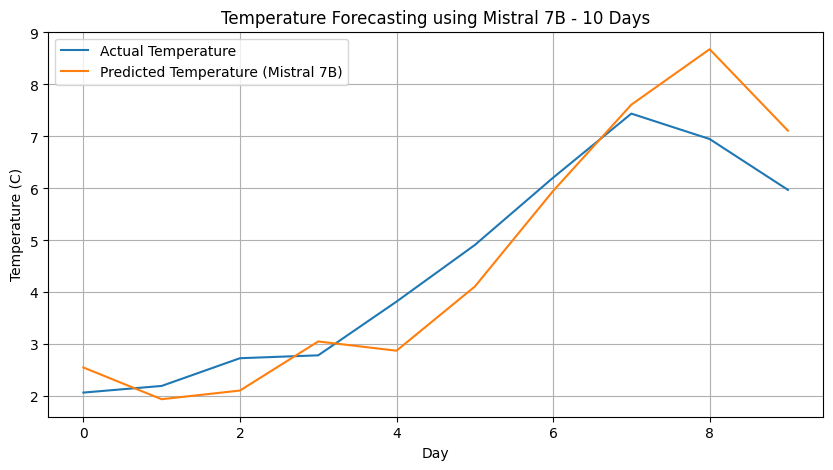

CPU times: user 7.45 s, sys: 280 ms, total: 7.73 s
Wall time: 7.82 s


In [26]:
%%time

# Take a small sample: first 10 days
X_sample = X[:10]
ten_days_y_actual = y[:10]

# Get predictions for the 10-day sample
ten_days_predictions = []
for idx, input_series in enumerate(X_sample):
    print(f"⏳ Predicting for day {idx + 1}/{len(X_sample)}")
    pred = query_mistral(input_series)
    ten_days_predictions.append(pred)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(range(len(ten_days_y_actual)), ten_days_y_actual, label='Actual Temperature')
plt.plot(range(len(ten_days_predictions)), ten_days_predictions, label='Predicted Temperature (Mistral 7B)')
plt.xlabel('Day')
plt.ylabel('Temperature (C)')
plt.title('Temperature Forecasting using Mistral 7B - 10 Days')
plt.legend()
plt.grid(True)
plt.show()

## 50 days

⏳ Predicting for day 1/50

 Raw Mistral output: Given the past 7 daily temperatures: [0.5777777777777773, 1.161111111111113, 1.6666666666666667, 1.71111111111111, 1.183333333333335, 1.2055555555555566, 2.2222222222222223], predict the next day's temperature. Reply with a number.
Answer: 2.555
⏳ Predicting for day 2/50

 Raw Mistral output: Given the past 7 daily temperatures: [1.161111111111113, 1.6666666666666667, 1.71111111111111, 1.183333333333335, 1.2055555555555566, 2.2222222222222223, 2.0722222222222206], predict the next day's temperature. Reply with a number.
A: 1.9444
⏳ Predicting for day 3/50

 Raw Mistral output: Given the past 7 daily temperatures: [1.6666666666666667, 1.71111111111111, 1.183333333333335, 1.2055555555555566, 2.2222222222222223, 2.0722222222222206, 2.2000000000000006], predict the next day's temperature. Reply with a number.
A: 2.1111
⏳ Predicting for day 4/50

 Raw Mistral output: Given the past 7 daily temperatures: [1.71111111111111, 1.183333333333335, 1.

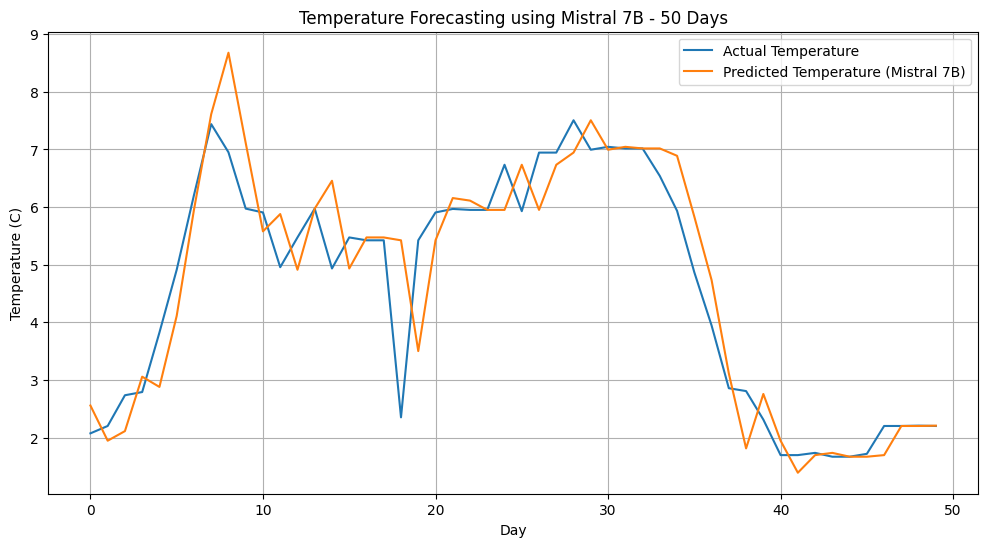

CPU times: user 36 s, sys: 1.25 s, total: 37.3 s
Wall time: 38.6 s


In [27]:
%%time
# Take a larger sample: first 50 days
X_sample = X[:50]
fifty_days_y_actual = y[:50]

# Get predictions for the 50-day sample
fifty_days_predictions = []
for idx, input_series in enumerate(X_sample):
    print(f"⏳ Predicting for day {idx + 1}/{len(X_sample)}")
    pred = query_mistral(input_series)
    fifty_days_predictions.append(pred)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(range(len(fifty_days_y_actual)), fifty_days_y_actual, label='Actual Temperature')
plt.plot(range(len(fifty_days_predictions)), fifty_days_predictions, label='Predicted Temperature (Mistral 7B)')
plt.xlabel('Day')
plt.ylabel('Temperature (C)')
plt.title('Temperature Forecasting using Mistral 7B - 50 Days')
plt.legend()
plt.grid(True)
plt.show()

## Metrics

## 10 days

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(ten_days_y_actual, ten_days_predictions))
print(f"RMSE: {rmse:.4f} °C")

# Calculate MAE
mae = mean_absolute_error(ten_days_y_actual, ten_days_predictions)
print(f"MAE: {mae:.4f} °C")

# Calculate R²
r2 = r2_score(ten_days_y_actual, ten_days_predictions)
print(f"R²: {r2:.4f}")

RMSE: 0.8164 °C
MAE: 0.6666 °C
R²: 0.8226


## 50 days

In [29]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(fifty_days_y_actual, fifty_days_predictions))
print(f"RMSE: {rmse:.4f} °C")

# Calculate MAE
mae = mean_absolute_error(fifty_days_y_actual, fifty_days_predictions)
print(f"MAE: {mae:.4f} °C")

# Calculate R²
r2 = r2_score(fifty_days_y_actual, fifty_days_predictions)
print(f"R²: {r2:.4f}")

RMSE: 0.7902 °C
MAE: 0.5304 °C
R²: 0.8420
